In [1]:
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
from collections import Counter

# 이미지 폴더 경로

In [13]:
IMAGE_BASE_PATH = "dataset/test"

In [3]:
# 클래스 이름과 색상 설정
class_names = {0: 'General', 1: 'paper', 2: 'pack', 3: 'Metal', 4: 'Glass', 
               5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}

class_colors = {
    0: (255, 0, 0),    # Red
    1: (0, 255, 0),    # Green
    2: (0, 0, 255),    # Blue
    3: (255, 255, 0),  # Yellow
    4: (255, 0, 255),  # Magenta
    5: (0, 255, 255),  # Cyan
    6: (128, 0, 128),  # Purple
    7: (128, 128, 0),  # Olive
    8: (0, 128, 128),  # Teal
    9: (128, 128, 128) # Gray
}

In [4]:
# Prediction String을 파싱하는 함수
def parse_prediction_string(pred_string):
    if not isinstance(pred_string, str) or not pred_string.strip():
        return []  # 빈 Prediction String 처리
    pred_data = pred_string.split()
    bbox_data = []
    for i in range(0, len(pred_data), 6):
        class_id = int(pred_data[i])
        score = float(pred_data[i+1])
        x_min = float(pred_data[i+2])
        y_min = float(pred_data[i+3])
        x_max = float(pred_data[i+4])
        y_max = float(pred_data[i+5])
        bbox_data.append((class_id, score, x_min, y_min, x_max, y_max))
    return bbox_data

# 바운딩 박스를 시각화하는 함수
def visualize_bboxes_with_class(image_path, bboxes):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    for bbox in bboxes:
        class_id, score, x_min, y_min, x_max, y_max = bbox
        color = class_colors.get(class_id, (255, 0, 0))  # 기본 색상
        
        # 바운딩 박스와 클래스 이름 그리기
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 2)
        label = f"{class_names.get(class_id, 'Unknown')}: {score:.2f}"
        font_scale = 1.2  # 폰트 크기
        thickness = 2      # 두께
        
        cv2.putText(image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)
    
    return image

# 주어진 인덱스부터 3개의 이미지를 시각화하는 함수
def display_images_batch(dfs, start_index):
    n = len(dfs)  # 입력받은 CSV 파일 개수
    if start_index < 0 or start_index >= len(dfs[0]):
        print(f"Start index {start_index} is out of bounds.")
        return
    
    end_index = min(start_index + 3, len(dfs[0]))
    
    fig, axes = plt.subplots(3, n, figsize=(40, 30))

    # 1차원 배열일 경우 인덱싱 처리
    if n == 1:
        axes = axes.reshape(-1, 1)
    
    for i, df in enumerate(dfs):
        batch_df = df.iloc[start_index:end_index]
        
        for idx, row in enumerate(batch_df.itertuples()):
            image_path = f"dataset/test/{row.image_id.split('/')[-1]}"
            prediction_string = row.PredictionString
            
            # 바운딩 박스 파싱
            bboxes = parse_prediction_string(prediction_string)
            
            # 바운딩 박스 시각화
            image_with_bboxes = visualize_bboxes_with_class(image_path, bboxes)
            
            # 이미지를 그리드에 표시
            axes[idx, i].imshow(image_with_bboxes)
            axes[idx, i].axis('off')
            axes[idx, i].set_title(f"Image {start_index + idx}, CSV {i+1}")
    
    plt.tight_layout()
    plt.show()



# 신뢰도가 낮은 클래스 분포를 시각화하는 함수
def visualize_low_confidence_distribution(dfs, score_threshold=0.5):
    n = len(dfs)  # 입력받은 CSV 파일 개수
    
    # 단일 CSV 파일일 경우 `axes`는 단일 객체, 여러 개일 경우 `axes`는 배열이 됩니다.
    fig, axes = plt.subplots(1, n, figsize=(20, 5))

    # `axes`가 단일 객체일 경우 배열로 처리하지 않도록 수정
    if n == 1:
        axes = [axes]  # 단일 객체를 리스트로 변환하여 일관성 있게 처리

    for i, df in enumerate(dfs):
        class_count = Counter()  # 클래스 빈도를 저장할 Counter
        
        # 모든 이미지에 대해 Prediction String을 분석
        for row in df.itertuples():
            prediction_string = row.PredictionString
            bboxes = parse_prediction_string(prediction_string)
            
            # 신뢰도가 낮은 바운딩 박스만 카운트
            for class_id, score, _, _, _, _ in bboxes:
                if score < score_threshold:
                    class_count[class_id] += 1

        # 클래스 이름과 그 빈도를 저장
        classes = [class_names[class_id] for class_id in class_count.keys()]
        counts = list(class_count.values())

        # 클래스 분포를 막대 그래프로 시각화
        axes[i].bar(classes, counts, color='skyblue')
        axes[i].set_xlabel('Class')
        axes[i].set_ylabel('Count')
        axes[i].set_title(f'CSV {i+1} - Confidence < {score_threshold}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# 사용자 입력을 통해 CSV 파일 경로들을 받기
def input_csv_paths():
    num_csv = int(input("비교할 CSV 파일 개수를 입력하세요 (0이면 종료): "))
    
    if num_csv == 0:
        print("종료합니다.")
        return []
    
    csv_paths = []
    for i in range(num_csv):
        path = input(f"{i + 1}번째 CSV 파일 경로를 입력하세요: ")
        csv_paths.append(path)
    
    return csv_paths

# 바운딩 박스가 없는 이미지들의 리스트를 출력하는 함수
def list_images_without_bboxes(dfs):
    result = []  # 모든 CSV 파일에서 바운딩 박스가 없는 이미지들을 저장할 리스트
    
    for i, df in enumerate(dfs):
        no_bbox_images = []  # 현재 CSV에서 바운딩 박스가 없는 이미지들의 리스트
        for row in df.itertuples():
            prediction_string = row.PredictionString
            
            # PredictionString이 비어 있는지 확인
            if not isinstance(prediction_string, str) or not prediction_string.strip():
                no_bbox_images.append(row.image_id)
        
        result.append(no_bbox_images)
        print(f"CSV {i+1}에서 바운딩 박스가 없는 이미지들: {no_bbox_images}")
    
    return result


# CSV 개수 경로 입력

In [5]:
# CSV 파일 경로를 입력받고 데이터프레임을 생성합니다.
csv_paths = []
num_csv = int(input("비교할 CSV 파일 개수를 입력하세요 (0이면 종료): "))

if num_csv == 0:
    print("종료합니다.")
else:
    for i in range(num_csv):
        path = input(f"{i + 1}번째 CSV 파일 경로를 입력하세요: ")
        csv_paths.append(path)

dfs = [pd.read_csv(path) for path in csv_paths]

# 데이터를 성공적으로 불러왔는지 확인
print(f"{num_csv}개의 CSV 파일이 로드되었습니다.")

비교할 CSV 파일 개수를 입력하세요 (0이면 종료):  3
1번째 CSV 파일 경로를 입력하세요:  11x.csv
2번째 CSV 파일 경로를 입력하세요:  submission_yolo8_mosaic_100.csv
3번째 CSV 파일 경로를 입력하세요:  cascade_swinL_568.csv


3개의 CSV 파일이 로드되었습니다.


In [10]:
dfs

[                                       PredictionString       image_id
 0     7 0.980955 603.2 518.9 957.3 1024.0 7 0.975663...  test/0000.jpg
 1     5 0.917555 130.1 0.0 493.0 268.4 5 0.901212 34...  test/0001.jpg
 2     1 0.946920 425.0 268.6 640.8 327.8 1 0.942371 ...  test/0002.jpg
 3     9 0.568191 143.5 259.9 911.5 821.8 9 0.426235 ...  test/0003.jpg
 4     0 0.843715 424.4 409.2 656.2 576.9 0 0.510021 ...  test/0004.jpg
 ...                                                 ...            ...
 4866                 1 0.906246 293.4 347.9 669.0 687.4  test/4866.jpg
 4867                 4 0.595803 416.2 329.8 782.9 702.8  test/4867.jpg
 4868  7 0.940200 113.8 443.4 757.7 835.7 0 0.561204 ...  test/4868.jpg
 4869  1 0.717209 836.9 0.0 912.1 247.1 1 0.711782 84...  test/4869.jpg
 4870  4 0.980695 373.4 204.6 624.7 844.3 4 0.843117 ...  test/4870.jpg
 
 [4871 rows x 2 columns],
                                        PredictionString       image_id
 0     7 0.959836 118.6 422.8 330.7 

# 바운딩 박스가 탐지되지 않은 이미지 데이터

In [9]:
no_bbox_images = list_images_without_bboxes(dfs)

CSV 1에서 바운딩 박스가 없는 이미지들: ['test/0017.jpg', 'test/0044.jpg', 'test/0337.jpg', 'test/0695.jpg', 'test/0882.jpg', 'test/1291.jpg', 'test/1329.jpg', 'test/1474.jpg', 'test/1497.jpg', 'test/1528.jpg', 'test/2122.jpg', 'test/2150.jpg', 'test/2816.jpg', 'test/2983.jpg', 'test/3389.jpg', 'test/3664.jpg', 'test/4051.jpg', 'test/4859.jpg']
CSV 2에서 바운딩 박스가 없는 이미지들: ['test/0137.jpg', 'test/0159.jpg', 'test/0551.jpg', 'test/0680.jpg', 'test/0731.jpg', 'test/0879.jpg', 'test/0882.jpg', 'test/1208.jpg', 'test/1291.jpg', 'test/1343.jpg', 'test/1474.jpg', 'test/1528.jpg', 'test/1565.jpg', 'test/1652.jpg', 'test/1709.jpg', 'test/1772.jpg', 'test/2085.jpg', 'test/2122.jpg', 'test/2150.jpg', 'test/2283.jpg', 'test/2331.jpg', 'test/2352.jpg', 'test/2597.jpg', 'test/2671.jpg', 'test/2684.jpg', 'test/2816.jpg', 'test/2922.jpg', 'test/2983.jpg', 'test/3003.jpg', 'test/3033.jpg', 'test/3124.jpg', 'test/3312.jpg', 'test/3397.jpg', 'test/3741.jpg', 'test/3770.jpg', 'test/4042.jpg', 'test/4200.jpg', 'test/4205.jp

# 인덱스부터 3개의 이미지를 시각화

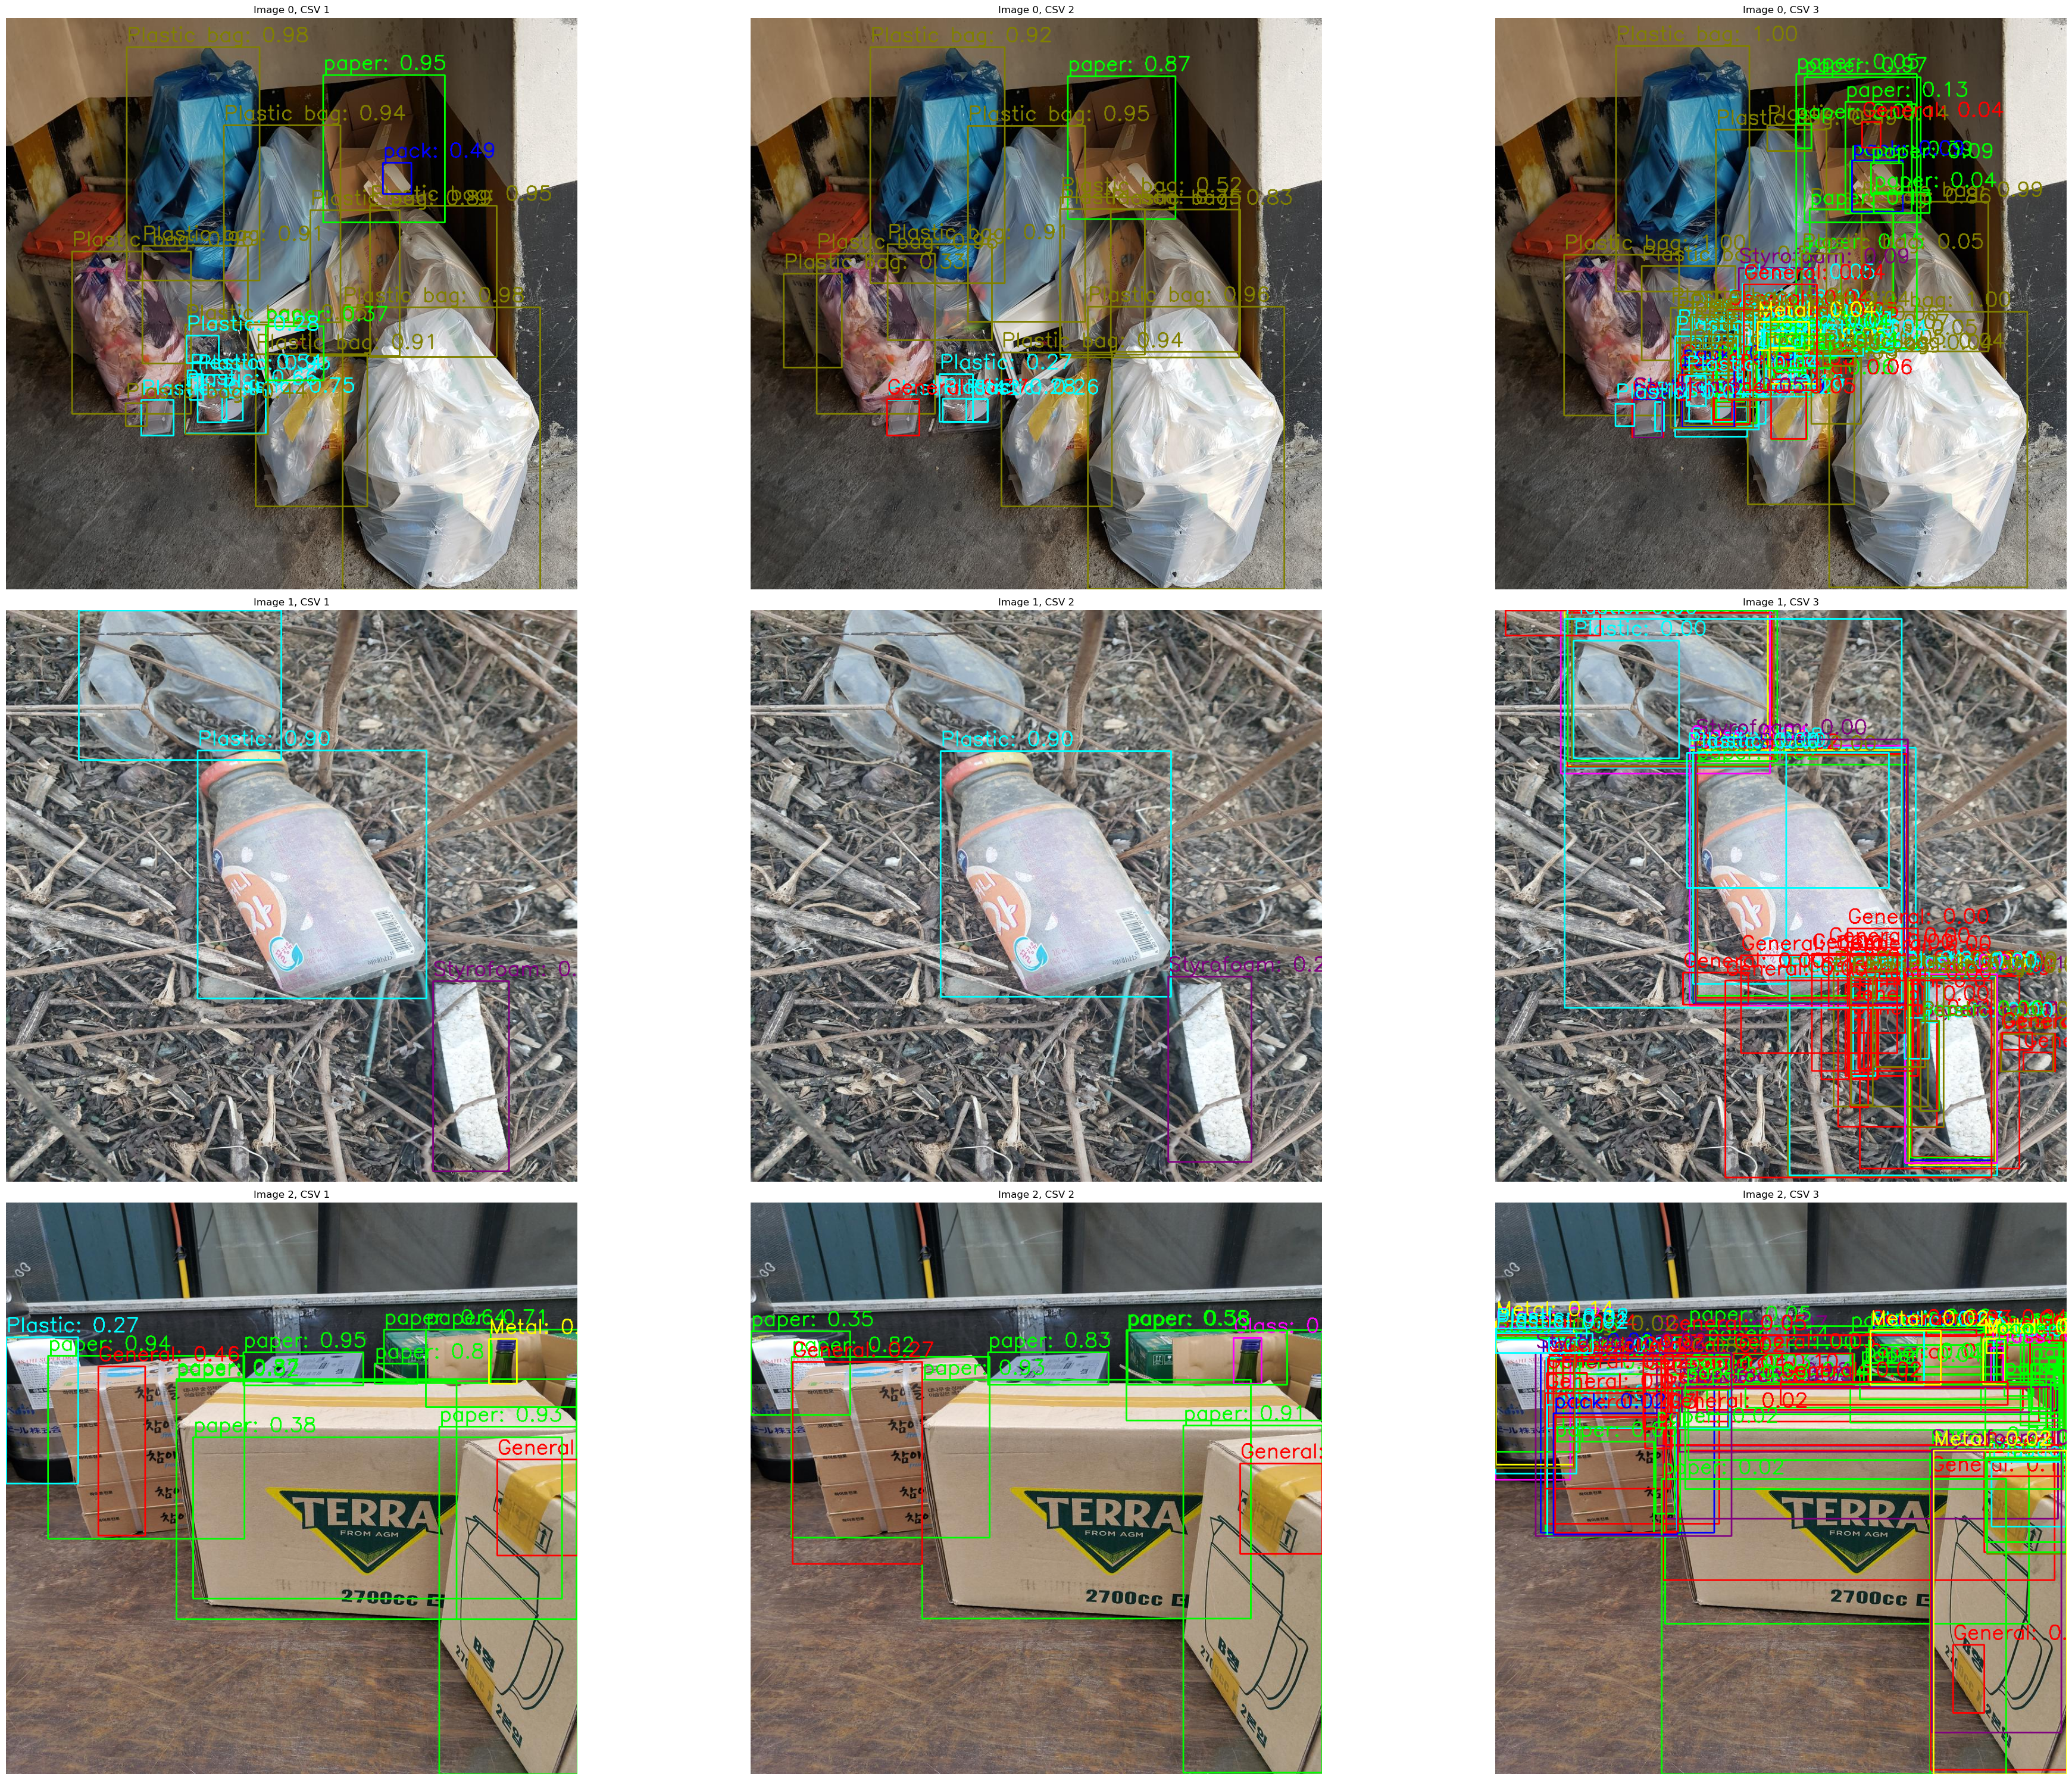

In [11]:
idx = 0
display_images_batch(dfs, idx)

# 신뢰도가 낮은 클래스 분포 시각화

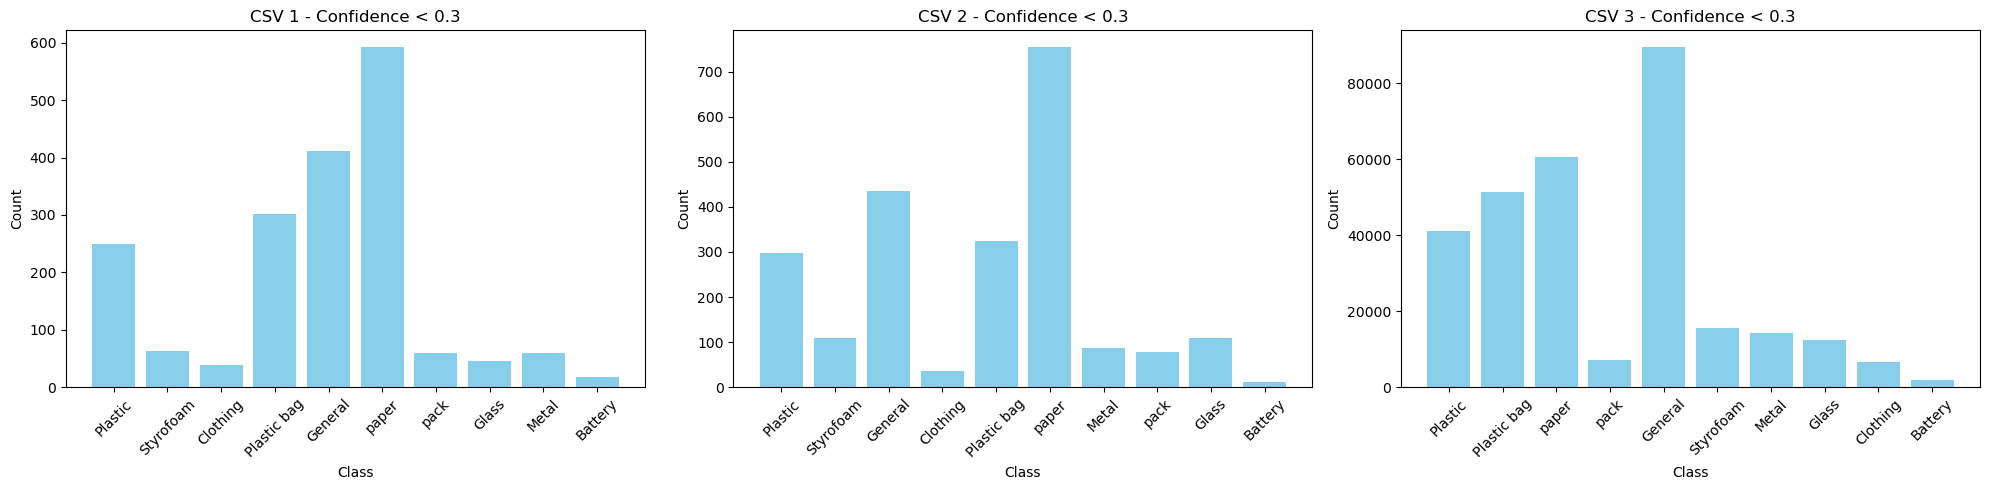

In [12]:
score_threshold = 0.3
visualize_low_confidence_distribution(dfs, score_threshold)